# Tennessee Eastman Process Simulator - Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jkitchin/tennessee-eastman-profbraatz/blob/master/examples/introduction.ipynb)

This notebook provides an introduction to the Tennessee Eastman Process (TEP) simulator, demonstrating:

1. Basic fault-free simulation
2. Simulation with a fault and visualization of measurement changes
3. Using closed-loop control
4. Real-time fault detection using the plugin system

The TEP is a widely-used benchmark for process control and fault detection research, simulating a realistic chemical process with a reactor, separator, stripper, and compressor.

In [1]:
# Uncomment and run this cell to install the package in Google Colab
# !pip install git+https://github.com/jkitchin/tennessee-eastman-profbraatz

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tep import TEPSimulator, DISTURBANCE_NAMES, MEASUREMENT_NAMES
from tep.simulator import ControlMode

## 1. Basic Fault-Free Simulation

Let's start with a simple simulation under normal operating conditions. The TEP simulator runs in closed-loop mode by default, with decentralized PI controllers maintaining stable operation.

In [3]:
# Create simulator with a fixed random seed for reproducibility
sim = TEPSimulator(random_seed=12345, control_mode=ControlMode.CLOSED_LOOP)

# Initialize to steady state
sim.initialize()

# Check initial conditions
xmeas = sim.get_measurements()
print("Initial Conditions:")
print(f"  Reactor Temperature: {xmeas[8]:.1f} °C")
print(f"  Reactor Pressure:    {xmeas[6]:.1f} kPa")
print(f"  Reactor Level:       {xmeas[7]:.1f} %")

Initial Conditions:
  Reactor Temperature: 120.4 °C
  Reactor Pressure:    2705.0 kPa
  Reactor Level:       75.0 %


In [4]:
# Run a 2-hour simulation with no faults
result = sim.simulate(
    duration_hours=2.0,
    record_interval=60  # Record every 60 seconds
)

print(f"Simulation completed!")
print(f"  Duration: {result.time[-1]:.2f} hours")
print(f"  Data points: {len(result.time)}")
print(f"  Shutdown: {result.shutdown}")

Simulation completed!
  Duration: 2.00 hours
  Data points: 121
  Shutdown: False


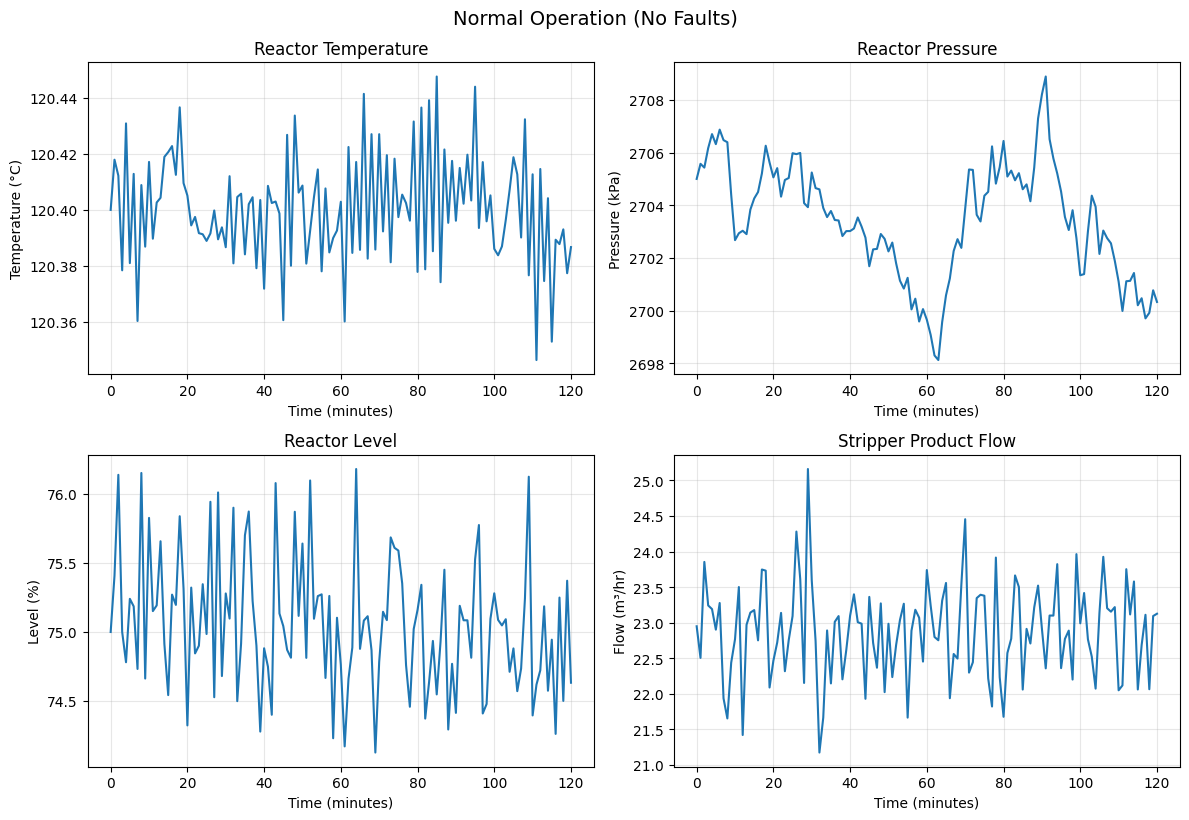

In [5]:
# Plot key process variables during normal operation
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Reactor temperature
axes[0, 0].plot(result.time_minutes, result.measurements[:, 8])
axes[0, 0].set_xlabel('Time (minutes)')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_title('Reactor Temperature')
axes[0, 0].grid(True, alpha=0.3)

# Reactor pressure
axes[0, 1].plot(result.time_minutes, result.measurements[:, 6])
axes[0, 1].set_xlabel('Time (minutes)')
axes[0, 1].set_ylabel('Pressure (kPa)')
axes[0, 1].set_title('Reactor Pressure')
axes[0, 1].grid(True, alpha=0.3)

# Reactor level
axes[1, 0].plot(result.time_minutes, result.measurements[:, 7])
axes[1, 0].set_xlabel('Time (minutes)')
axes[1, 0].set_ylabel('Level (%)')
axes[1, 0].set_title('Reactor Level')
axes[1, 0].grid(True, alpha=0.3)

# Product flow
axes[1, 1].plot(result.time_minutes, result.measurements[:, 16])
axes[1, 1].set_xlabel('Time (minutes)')
axes[1, 1].set_ylabel('Flow (m³/hr)')
axes[1, 1].set_title('Stripper Product Flow')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Normal Operation (No Faults)', y=1.02, fontsize=14)
plt.show()

## 2. Simulation with a Fault

The TEP includes 20 pre-programmed process disturbances (faults). Let's simulate **IDV(4): Reactor Cooling Water Inlet Temperature Step Change**, which is one of the easier faults to detect.

First, let's see what faults are available:

In [6]:
# Show available disturbances
print("Available Process Disturbances (Faults):")
print("=" * 60)
for i, name in enumerate(DISTURBANCE_NAMES[:15], 1):
    print(f"  IDV({i:2d}): {name}")
print("  ...")
print(f"  IDV(16-20): Unknown (reserved for testing)")

Available Process Disturbances (Faults):
  IDV( 1): A/C Feed Ratio, B Composition Constant (Step)
  IDV( 2): B Composition, A/C Ratio Constant (Step)
  IDV( 3): D Feed Temperature (Step)
  IDV( 4): Reactor Cooling Water Inlet Temperature (Step)
  IDV( 5): Condenser Cooling Water Inlet Temperature (Step)
  IDV( 6): A Feed Loss (Step)
  IDV( 7): C Header Pressure Loss (Step)
  IDV( 8): A, B, C Feed Composition (Random Variation)
  IDV( 9): D Feed Temperature (Random Variation)
  IDV(10): C Feed Temperature (Random Variation)
  IDV(11): Reactor Cooling Water Inlet Temp (Random Variation)
  IDV(12): Condenser Cooling Water Inlet Temp (Random Var)
  IDV(13): Reaction Kinetics (Slow Drift)
  IDV(14): Reactor Cooling Water Valve (Sticking)
  IDV(15): Condenser Cooling Water Valve (Sticking)
  ...
  IDV(16-20): Unknown (reserved for testing)


In [7]:
# Create a new simulator and run with fault IDV(4)
sim = TEPSimulator(random_seed=12345, control_mode=ControlMode.CLOSED_LOOP)
sim.initialize()

# Simulate for 4 hours, with fault starting at t=1 hour
result_fault = sim.simulate(
    duration_hours=4.0,
    disturbances={4: (1.0, 1)},  # IDV(4) activates at t=1 hour
    record_interval=60
)

print(f"Simulation with IDV(4) completed!")
print(f"  Fault: {DISTURBANCE_NAMES[3]}")
print(f"  Fault onset: 1.0 hours")
print(f"  Shutdown: {result_fault.shutdown}")

Simulation with IDV(4) completed!
  Fault: Reactor Cooling Water Inlet Temperature (Step)
  Fault onset: 1.0 hours
  Shutdown: False


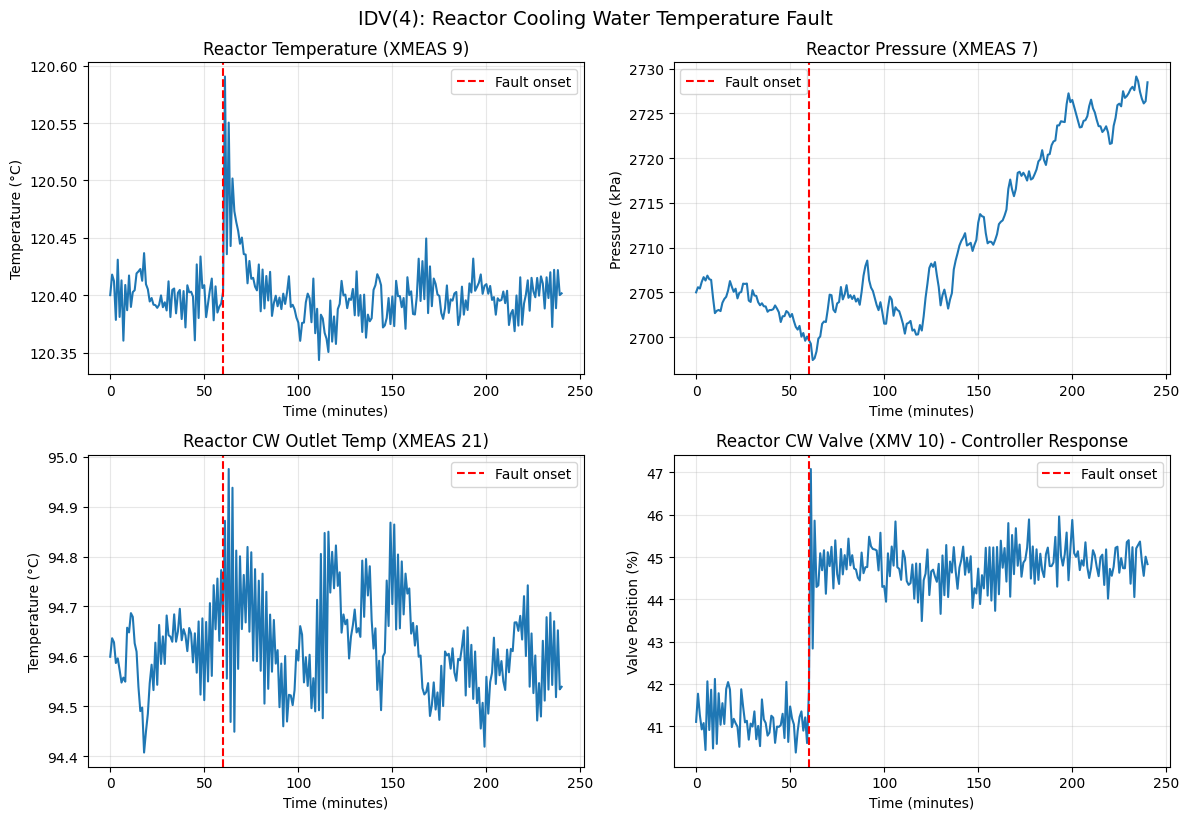

In [8]:
# Plot the most significant measurement changes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

fault_time = 60  # Fault at 60 minutes

# Reactor temperature - increases significantly with cooling water fault
axes[0, 0].plot(result_fault.time_minutes, result_fault.measurements[:, 8])
axes[0, 0].axvline(x=fault_time, color='r', linestyle='--', label='Fault onset')
axes[0, 0].set_xlabel('Time (minutes)')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_title('Reactor Temperature (XMEAS 9)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Reactor pressure - rises due to increased temperature
axes[0, 1].plot(result_fault.time_minutes, result_fault.measurements[:, 6])
axes[0, 1].axvline(x=fault_time, color='r', linestyle='--', label='Fault onset')
axes[0, 1].set_xlabel('Time (minutes)')
axes[0, 1].set_ylabel('Pressure (kPa)')
axes[0, 1].set_title('Reactor Pressure (XMEAS 7)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Cooling water outlet temperature - direct indicator of the fault
axes[1, 0].plot(result_fault.time_minutes, result_fault.measurements[:, 20])
axes[1, 0].axvline(x=fault_time, color='r', linestyle='--', label='Fault onset')
axes[1, 0].set_xlabel('Time (minutes)')
axes[1, 0].set_ylabel('Temperature (°C)')
axes[1, 0].set_title('Reactor CW Outlet Temp (XMEAS 21)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Reactor cooling water flow (manipulated variable) - controller response
axes[1, 1].plot(result_fault.time_minutes, result_fault.manipulated_vars[:, 9])
axes[1, 1].axvline(x=fault_time, color='r', linestyle='--', label='Fault onset')
axes[1, 1].set_xlabel('Time (minutes)')
axes[1, 1].set_ylabel('Valve Position (%)')
axes[1, 1].set_title('Reactor CW Valve (XMV 10) - Controller Response')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('IDV(4): Reactor Cooling Water Temperature Fault', y=1.02, fontsize=14)
plt.show()

The plots show the characteristic response to IDV(4):
- **Reactor temperature** increases as the cooling water becomes less effective
- **Reactor pressure** rises due to the increased temperature
- **Cooling water outlet temperature** increases (direct effect of the fault)
- **Cooling water valve** opens further as the controller tries to compensate

## 3. Closed-Loop Control

The simulator includes a decentralized PI control system based on Ricker (1996). Let's compare the process behavior with and without control during a fault.

In [9]:
# Closed-loop simulation (default)
sim_closed = TEPSimulator(random_seed=42, control_mode=ControlMode.CLOSED_LOOP)
sim_closed.initialize()
result_closed = sim_closed.simulate(
    duration_hours=3.0,
    disturbances={1: (0.5, 1)},  # IDV(1) at 30 minutes
    record_interval=60
)

# Open-loop simulation (no control)
sim_open = TEPSimulator(random_seed=42, control_mode=ControlMode.OPEN_LOOP)
sim_open.initialize()
result_open = sim_open.simulate(
    duration_hours=3.0,
    disturbances={1: (0.5, 1)},  # IDV(1) at 30 minutes
    record_interval=60
)

print(f"Closed-loop shutdown: {result_closed.shutdown}")
print(f"Open-loop shutdown:   {result_open.shutdown}")

Closed-loop shutdown: False
Open-loop shutdown:   True


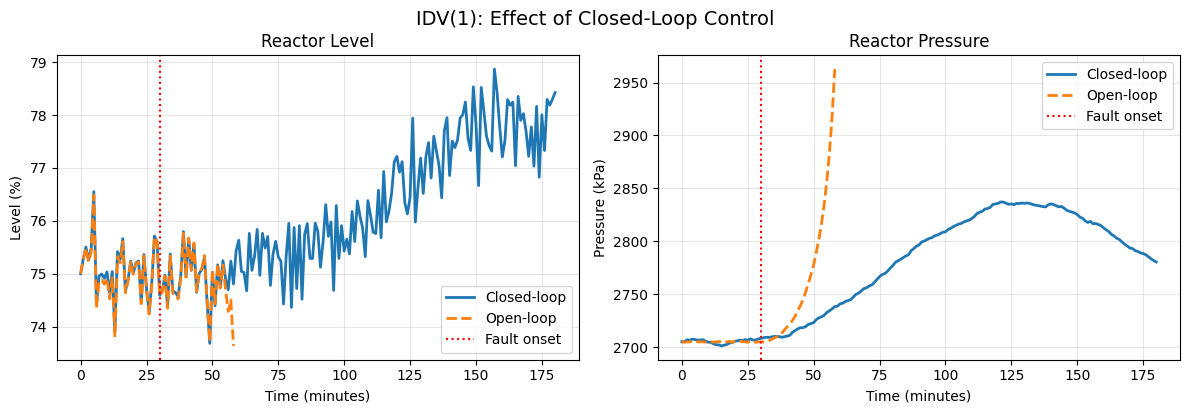

In [10]:
# Compare reactor level with and without control
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

fault_time = 30  # minutes

# Reactor level
axes[0].plot(result_closed.time_minutes, result_closed.measurements[:, 7], 
             label='Closed-loop', linewidth=2)
axes[0].plot(result_open.time_minutes[:len(result_open.measurements)], 
             result_open.measurements[:, 7], 
             label='Open-loop', linewidth=2, linestyle='--')
axes[0].axvline(x=fault_time, color='r', linestyle=':', label='Fault onset')
axes[0].set_xlabel('Time (minutes)')
axes[0].set_ylabel('Level (%)')
axes[0].set_title('Reactor Level')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reactor pressure
axes[1].plot(result_closed.time_minutes, result_closed.measurements[:, 6], 
             label='Closed-loop', linewidth=2)
axes[1].plot(result_open.time_minutes[:len(result_open.measurements)], 
             result_open.measurements[:, 6], 
             label='Open-loop', linewidth=2, linestyle='--')
axes[1].axvline(x=fault_time, color='r', linestyle=':', label='Fault onset')
axes[1].set_xlabel('Time (minutes)')
axes[1].set_ylabel('Pressure (kPa)')
axes[1].set_title('Reactor Pressure')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('IDV(1): Effect of Closed-Loop Control', y=1.02, fontsize=14)
plt.show()

## 4. Using the Fault Detection Plugin System

The TEP package includes a fault detection plugin system with several built-in detectors. Let's explore how to use them for real-time fault detection during simulation.

In [11]:
from tep.detector_base import FaultDetectorRegistry

# List available detectors
print("Available Fault Detectors:")
print("=" * 60)
for name in FaultDetectorRegistry.list_available():
    info = FaultDetectorRegistry.get_info(name)
    print(f"  {name:15s} - {info['description']}")

Available Fault Detectors:
  threshold       - Fast threshold-based detection using process safety limits
  ewma            - Exponentially Weighted Moving Average change detector
  cusum           - Cumulative Sum control chart for drift detection
  pca             - PCA-based detection with T² and SPE statistics
  statistical     - Multi-statistic ensemble detector
  sliding_window  - Simple sliding window comparison detector
  composite       - Combines multiple detectors with voting
  passthrough     - Always reports normal (baseline for comparison)


In [12]:
# First, run a baseline simulation to establish mean and std
print("Running baseline simulation for normal operation (60 minutes)...")
baseline_sim = TEPSimulator(random_seed=42, control_mode=ControlMode.CLOSED_LOOP)
baseline_sim.initialize()

# Collect baseline data (60 minutes of normal operation)
baseline_steps = 3600  # 60 minutes
baseline_data = []

for step in range(baseline_steps):
    baseline_sim.step()
    if step % 10 == 0:  # Sample every 10 steps
        baseline_data.append(baseline_sim.get_measurements().copy())

baseline_data = np.array(baseline_data)

# Calculate baseline statistics
baseline_mean = np.mean(baseline_data, axis=0)
baseline_std = np.std(baseline_data, axis=0)

print(f"Baseline collected: {len(baseline_data)} samples over {baseline_steps/60:.0f} minutes")
print(f"Example - Reactor Pressure (XMEAS 7): mean={baseline_mean[6]:.1f} kPa, std={baseline_std[6]:.2f} kPa")

Running baseline simulation for normal operation (60 minutes)...
Baseline collected: 360 samples over 60 minutes
Example - Reactor Pressure (XMEAS 7): mean=2705.6 kPa, std=1.95 kPa


In [13]:
# Create threshold detector with learned baseline statistics
# Uses mean ± 3σ as detection thresholds, monitoring only reactor pressure
threshold_detector = FaultDetectorRegistry.create(
    "threshold",
    mean=baseline_mean,
    std=baseline_std,
    n_sigma=3.0,
    monitored_indices=[6]  # Only monitor reactor pressure (XMEAS 7, 0-indexed)
)

print(f"Created detector: {threshold_detector.name}")
print(f"Mode: Statistical (mean ± {threshold_detector.n_sigma}σ)")
print(f"\nMonitored variable:")
idx = 6
low, high = threshold_detector.limits[idx]
print(f"  Reactor Pressure (XMEAS 7): {low:.1f} to {high:.1f} kPa")

Created detector: threshold
Mode: Statistical (mean ± 3.0σ)

Monitored variable:
  Reactor Pressure (XMEAS 7): 2699.7 to 2711.4 kPa


In [14]:
# Run simulation: 30 min normal, then introduce IDV(6) A Feed Loss
sim = TEPSimulator(random_seed=42, control_mode=ControlMode.CLOSED_LOOP)
sim.initialize()

# Storage for detection results
times = []
detection_results = []
measurements = []

# Simulate: 30 min normal + 60 min with fault = 90 min total
fault_onset_step = 1800  # 30 minutes
total_steps = 5400  # 90 minutes

print("Running simulation...")
print(f"  Steps 0-{fault_onset_step} (0-30 min): Normal operation")
print(f"  Steps {fault_onset_step}-{total_steps} (30-90 min): IDV(6) A Feed Loss")

for step in range(total_steps):
    # Introduce fault at specified time
    if step == fault_onset_step:
        sim.set_disturbance(6, 1)  # IDV(6): A Feed Loss
    
    # Step the simulation
    sim.step()
    
    # Get current measurements
    xmeas = sim.get_measurements()
    
    # Process through detector (real-time!)
    result = threshold_detector.process(xmeas, step)
    
    # Record every 10 steps
    if step % 10 == 0:
        times.append(step / 60)  # Convert to minutes
        measurements.append(xmeas.copy())
        detection_results.append(result)

print(f"\nSimulation completed: {total_steps} steps ({total_steps/60:.0f} minutes)")
print(f"IDV(6) A Feed Loss introduced at {fault_onset_step/60:.0f} minutes")

Running simulation...
  Steps 0-1800 (0-30 min): Normal operation
  Steps 1800-5400 (30-90 min): IDV(6) A Feed Loss

Simulation completed: 5400 steps (90 minutes)
IDV(6) A Feed Loss introduced at 30 minutes


In [15]:
# Analyze detection results
times = np.array(times)
measurements = np.array(measurements)

# Extract detection info
is_fault = np.array([r.is_fault for r in detection_results])

# Find first detection after fault onset
fault_time = fault_onset_step / 60  # minutes

post_fault_detections = np.where((times >= fault_time) & is_fault)[0]

print(f"Fault introduced at {fault_time:.0f} minutes\n")

if len(post_fault_detections) > 0:
    first_detection_idx = post_fault_detections[0]
    first_detection_time = times[first_detection_idx]
    detection_delay = first_detection_time - fault_time
    print(f"First detection: {first_detection_time:.1f} minutes")
    print(f"Detection delay: {detection_delay:.1f} minutes ({detection_delay*60:.0f} seconds)")
else:
    print("Fault not detected")

Fault introduced at 30 minutes

First detection: 34.3 minutes
Detection delay: 4.3 minutes (260 seconds)


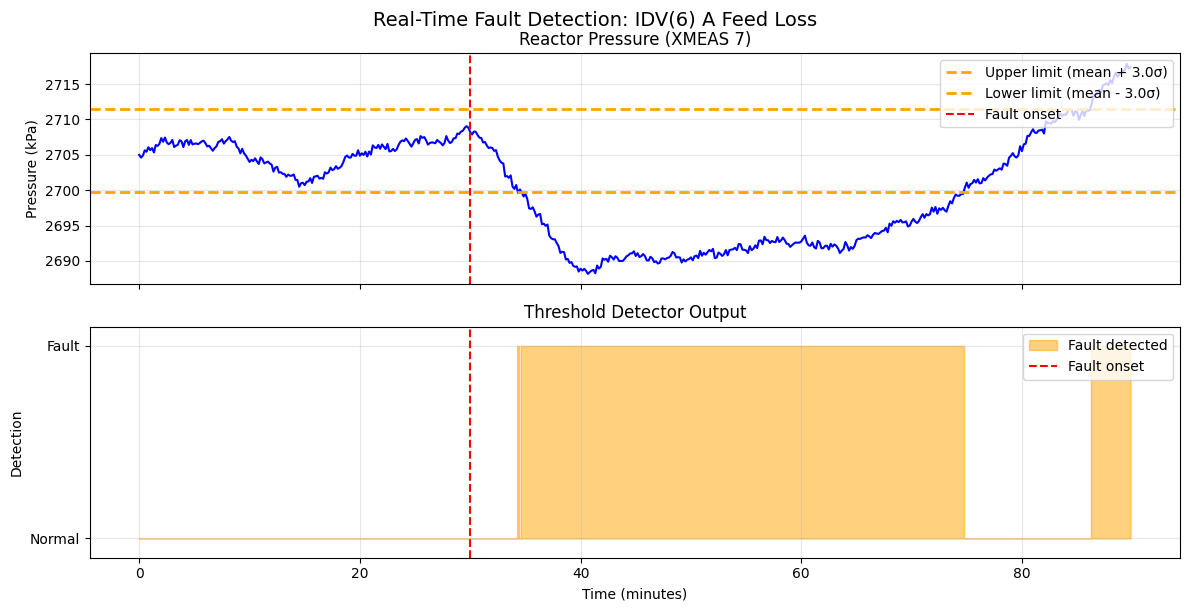

In [16]:
# Plot real-time detection results: Reactor Pressure and Detection Output
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

n_sigma = threshold_detector.n_sigma

# Reactor pressure with learned thresholds
pressure_idx = 6  # XMEAS 7 (0-indexed)
pressure_low, pressure_high = threshold_detector.limits[pressure_idx]
axes[0].plot(times, measurements[:, pressure_idx], 'b-', linewidth=1.5)
axes[0].axhline(y=pressure_high, color='orange', linestyle='--', linewidth=2, 
                label=f'Upper limit (mean + {n_sigma}σ)')
axes[0].axhline(y=pressure_low, color='orange', linestyle='--', linewidth=2, 
                label=f'Lower limit (mean - {n_sigma}σ)')
axes[0].axvline(x=fault_time, color='r', linestyle='--', label='Fault onset')
axes[0].set_ylabel('Pressure (kPa)')
axes[0].set_title('Reactor Pressure (XMEAS 7)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Detection output (binary)
detection_signal = is_fault.astype(int)
axes[1].fill_between(times, 0, detection_signal, alpha=0.5, color='orange', 
                     label='Fault detected', step='mid')
axes[1].axvline(x=fault_time, color='r', linestyle='--', label='Fault onset')
axes[1].set_xlabel('Time (minutes)')
axes[1].set_ylabel('Detection')
axes[1].set_title('Threshold Detector Output')
axes[1].set_ylim(-0.1, 1.1)
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Normal', 'Fault'])
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Real-Time Fault Detection: IDV(6) A Feed Loss', y=1.01, fontsize=14)
plt.show()

In [17]:
# Calculate detection metrics using ground truth
# Ground truth: fault is active after fault_time
ground_truth = times >= fault_time

# Metrics
true_positives = np.sum(is_fault & ground_truth)
false_positives = np.sum(is_fault & ~ground_truth)
true_negatives = np.sum(~is_fault & ~ground_truth)
false_negatives = np.sum(~is_fault & ground_truth)

total = len(times)
accuracy = (true_positives + true_negatives) / total
detection_rate = true_positives / np.sum(ground_truth) if np.sum(ground_truth) > 0 else 0
false_alarm_rate = false_positives / np.sum(~ground_truth) if np.sum(~ground_truth) > 0 else 0

print("Threshold Detector Performance Metrics:")
print("=" * 50)
print(f"  Total samples:                  {total}")
print(f"  True Positives:                 {true_positives}")
print(f"  False Positives:                {false_positives}")
print(f"  True Negatives:                 {true_negatives}")
print(f"  False Negatives:                {false_negatives}")
print(f"  Accuracy:                       {accuracy:.3f}")
print(f"  Fault Detection Rate (Recall):  {detection_rate:.3f}")
print(f"  False Alarm Rate:               {false_alarm_rate:.3f}")

Threshold Detector Performance Metrics:
  Total samples:                  540
  True Positives:                 264
  False Positives:                0
  True Negatives:                 180
  False Negatives:                96
  Accuracy:                       0.822
  Fault Detection Rate (Recall):  0.733
  False Alarm Rate:               0.000


## Summary

This notebook demonstrated the basic usage of the Tennessee Eastman Process simulator:

1. **Basic simulation** - Running fault-free simulations and accessing measurements
2. **Fault injection** - Applying process disturbances and observing their effects
3. **Control modes** - Comparing open-loop vs closed-loop behavior
4. **Fault detection** - Using built-in detectors to identify abnormal conditions

For more advanced usage, see the other examples in the `examples/` directory:
- `fault_detection.py` - Comprehensive fault detection examples
- `custom_controller.py` - Implementing custom control strategies
- `data_generation.py` - Generating datasets for machine learning
- `rieth2017_dataset.py` - Working with the Rieth 2017 benchmark dataset